## Introduction to the dataset

- World Health Organization has  estimated 12 million deaths occur worldwide, every year due to Heart diseases.

- Half the deaths in the United States and other developed countries are due to cardio vascular diseases. 

- The early prognosis of cardiovascular diseases can aid in making decisions on lifestyle changes in high risk patients and in turn reduce the complications.

- This research intends to pinpoint the most relevant/risk factors of heart disease as well as predict the overall risk using logistic regression.


In [1]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
from statsmodels.tools import add_constant as ac
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report,  mean_squared_error, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, Binarizer
sc = StandardScaler()
le = LabelEncoder()

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from collections import Counter
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
rfr = RandomForestRegressor()
rfc = RandomForestClassifier()
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Test
dfp = pd.read_csv('US_Heart_Patients.csv')
dfp.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [3]:
dfp.shape

(4240, 16)

In [4]:
target_var = 'TenYearCHD'

In [5]:
dfp.describe().T

,count,mean,std,min,25%,50%,75%,max
male,4240.0,0.429245,0.495027,0.00,0.00,0.0,1.00,1.0
age,4240.0,49.580189,8.572942,32.00,42.00,49.0,56.00,70.0
education,4135.0,1.979444,1.019791,1.00,1.00,2.0,3.00,4.0
currentSmoker,4240.0,0.494104,0.500024,0.00,0.00,0.0,1.00,1.0
cigsPerDay,4211.0,9.005937,11.922462,0.00,0.00,0.0,20.00,70.0
BPMeds,4187.0,0.029615,0.169544,0.00,0.00,0.0,0.00,1.0
prevalentStroke,4240.0,0.005896,0.076569,0.00,0.00,0.0,0.00,1.0
prevalentHyp,4240.0,0.310613,0.462799,0.00,0.00,0.0,1.00,1.0
diabetes,4240.0,0.025708,0.158280,0.00,0.00,0.0,0.00,1.0
totChol,4190.0,236.699523,44.591284,107.00,206.00,234.0,263.00,696.0


In [6]:
def cm_data(cm):
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    tp = cm[1, 1]
    print("Sensitivity: ", tp/(tp+fn))
    print("Specificity: ",tn/(tn+fp))
    print("Precision: ", tp/(tp+fp))
    print("Accuracy: ", (tp+tn)/(tp+tn+fp+fn))

In [7]:
def check_accuracy(test, pred, conf_mat = 'no'):
    acc = accuracy_score(test, pred)
    if conf_mat == 'yes':
        cm = confusion_matrix(test, pred)
        cm_df = pd.DataFrame(cm, columns=['Pred: 0', 'Pred: 1'], index = ['Obs: 0', 'Obs: 1'])
        # plt.figure(figsize=(10, 10))
        sns.heatmap(cm_df, annot=True, fmt='d')
        plt.show()
        cm_data(cm)
    return acc
    

In [8]:
# After the above function has run this function would be called and it would 
# print all accuracies along with the best one.

def print_best(name, x):
    print("No Sampling Done  :", x['not'])
    print("Over              :", x['o'])
    print("Under             :", x['u'])
    print("Both              :", x['b'])

    code = {
        'not': 'No Sampling Done',
        'o': 'SMOTE',
        'u': 'NearMiss',
        'b': 'SMOTE and Then NearMiss'
    }
    print("\nBest way in {} model is:".format(str(name)[:-2]), code[max(zip(x.values(), x.keys()))[1]])

In [9]:
# Purpose of the function is to determine which balancing technique is working the best.
# If we find one we would then rerun the function with that accuracy.

def all_samp_acc(model, params, df, cm = 'no'):

    if cm == 'yes':
        print("No Sampling: ")        
    _, no_samp_acc = grid_search(model = model, params = params, df = df, encod = 'd', cm=cm)
    
    if cm == 'yes':
        print("SMOTE: ")
    _, over_samp_acc = grid_search(model = model, params = params, df = df, samp = 'o', encod = 'd', cm=cm)
    
    if cm == 'yes':
        print("NearMiss: ")
    _, under_samp_acc = grid_search(model = model, params = params, df = df, samp = 'u', encod = 'd', cm=cm)
    
    if cm == 'yes':
        print("Both: ")
    _, both_samp_acc = grid_search(model = model, params = params, df = df, samp = 'b', encod = 'd', cm=cm)
    
    acc = {
    'not': no_samp_acc,
    'o': over_samp_acc,
    'u': under_samp_acc,
    'b': both_samp_acc
    }
    print_best(model, acc)  

In [10]:
# Check Multicollinearilty

def check_multicol(x):
    plt.figure(figsize=(20, 10))
    sns.heatmap(x.corr(), annot=True)
    plt.show()

In [11]:
# Implementing SMOTE

def smote(x, y):
    oversample = SMOTE(random_state = 2, sampling_strategy='minority')
    x = x.values
    y = y.values
    x, y = oversample.fit_resample(x, y)
    return x, y

In [12]:
# Implementing NearMiss

def near_miss(x, y):
    nr = NearMiss() 
    x_near, y_near= nr.fit_resample(x, y)
    return x_near, y_near

In [37]:
def grid_search(model, params, df, encod = 'd', samp = None, cm = 'no'):
    x_train, x_test, y_train, y_test = split_data(df)

    if encod == 'l':
        x_train = x_train.apply(LabelEncoder().fit_transform)
        x_test = x_test.apply(LabelEncoder().transform)
    else:
        x_train = pd.get_dummies(x_train, drop_first=True)
        x_test = pd.get_dummies(x_test, drop_first=True)
    
    if samp != None:
        if samp == 'o':
            x_train, y_train = smote(x_train, y_train)
        elif samp == 'u':
            x_train, y_train = near_miss(x_train, y_train)
        elif samp == 'b':
            x_train, y_train = smote(x_train, y_train)
            x_train, y_train = near_miss(x_train, y_train)

    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)
    grid_mod = GridSearchCV(model, param_grid=params, scoring = ['accuracy', 'f1'], cv = 10, n_jobs=-1, refit='accuracy')
    
    grid_mod.fit(x_train, y_train)

    y_pred = grid_mod.predict(x_test)

    if cm == 'yes':
        acc = check_accuracy(y_test, y_pred, conf_mat = 'yes')

    return grid_mod.best_estimator_, acc

In [14]:
def split_data(df, y = target_var):
    x = df.loc[:, df.columns != y]
    y = df.loc[:, y]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 123)
    # x_train, x_val, y_train, y_val =  train_test_split(x_train, y_train, test_size = 0.2, random_state = 123)

    return x_train, x_test, y_train, y_test

###  EDA and Feature Engineering

#### Univariate Analysis

In [15]:
# Caonverting object and numerical to category

to_be_cat = ['male', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'TenYearCHD']
dfp[to_be_cat]= dfp[to_be_cat].astype('category')
dfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   male             4240 non-null   category
 1   age              4240 non-null   int64   
 2   education        4135 non-null   category
 3   currentSmoker    4240 non-null   category
 4   cigsPerDay       4211 non-null   float64 
 5   BPMeds           4187 non-null   category
 6   prevalentStroke  4240 non-null   category
 7   prevalentHyp     4240 non-null   category
 8   diabetes         4240 non-null   category
 9   totChol          4190 non-null   float64 
 10  sysBP            4240 non-null   float64 
 11  diaBP            4240 non-null   float64 
 12  BMI              4221 non-null   float64 
 13  heartRate        4239 non-null   float64 
 14  glucose          3852 non-null   float64 
 15  TenYearCHD       4240 non-null   category
dtypes: category(8), float64(7), int64(1)
memor

In [16]:
not_to_plot = [] # contains column names which are not to be plotted. In this case we have none.
rand_color = ['red', 'blue', 'green']

In [17]:
def univariate(df, rows = 4, cols = 4):
    fig=plt.figure(figsize=(20,20))
    for j, i in enumerate(df.columns):
        ax=fig.add_subplot(rows,cols,j+1)
        if i in df.select_dtypes(['category']):
            sns.countplot(x= i, data = df, ax=ax)
        if i in df.select_dtypes(['int', 'float64']):
            sns.distplot(x = df[i], ax=ax, color=np.random.choice(rand_color))
    fig.tight_layout() 
    plt.show()

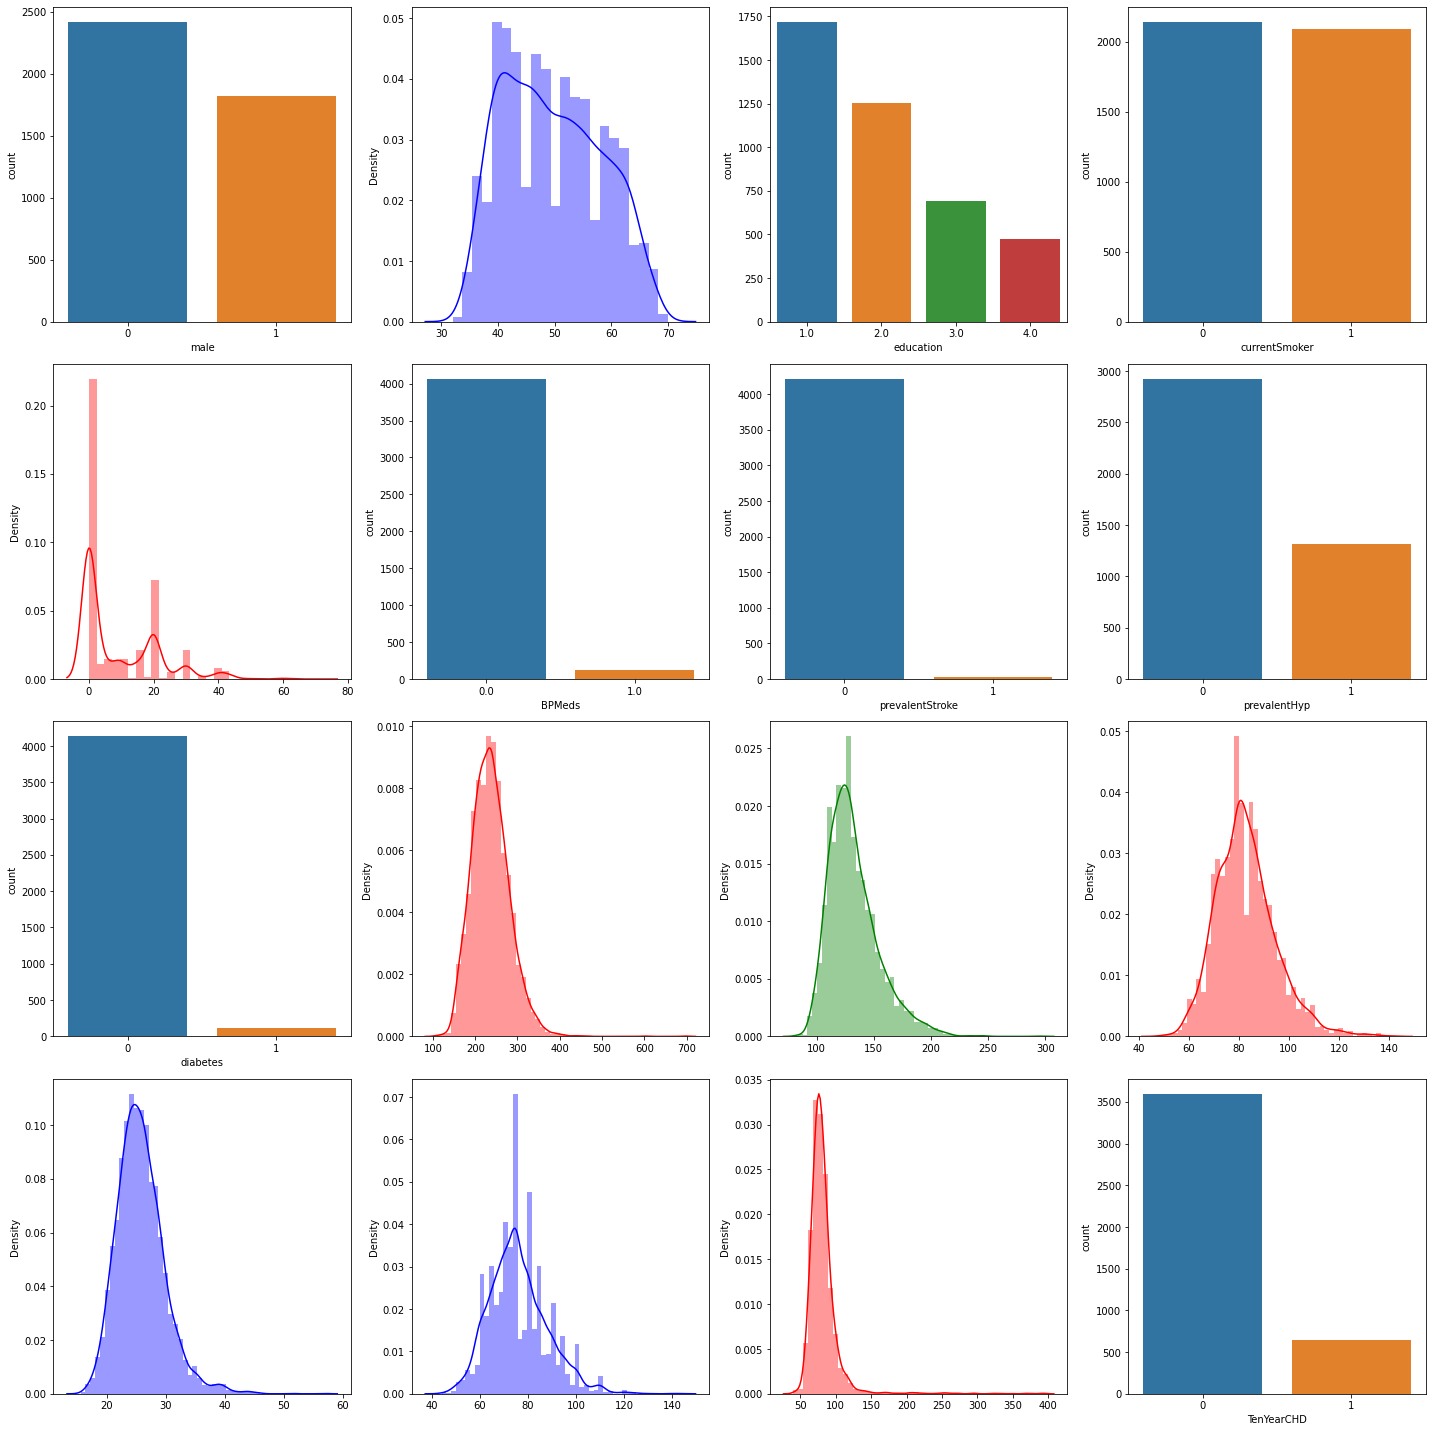

In [18]:
univariate(dfp)

#### Bivariate Analysis

In [23]:
def bivariate(df = dfp, y = target_var, cols = 4, rows = 4):
    temp = not_to_plot[:]
    temp.append(y)
    fig=plt.figure(figsize=(25,20))

    for j, i in enumerate(df.columns):
        if df[y].dtype == 'float':
            if i in df.select_dtypes(['category']):
                if (i not in temp): 
                    ax=fig.add_subplot(rows,cols,j+1)
                    sns.boxplot(x = i, y = y, data = df)

            if i in df.select_dtypes(['float', 'int']):                
                if (i not in temp):      
                    ax=fig.add_subplot(rows,cols,j+1)       
                    sns.scatterplot(x = y, y = i, data = df)                  
            
        elif df[y].dtype == 'category':
            if i in df.select_dtypes(['category']):
                if (i not in temp):
                    ax=fig.add_subplot(rows,cols,j+1)
                    sns.countplot(x = i, hue = y, data = df)
                    plt.legend(bbox_to_anchor=(1, 1), loc=2, labels=['Not Survived', 'Survived'], borderaxespad=0.)

            if i in df.select_dtypes(['float', 'int']):
                if (i not in temp):
                    ax=fig.add_subplot(rows,cols,j+1)
                    sns.boxplot(x = y, y = i, data = df)
    fig.tight_layout() 
    plt.show()

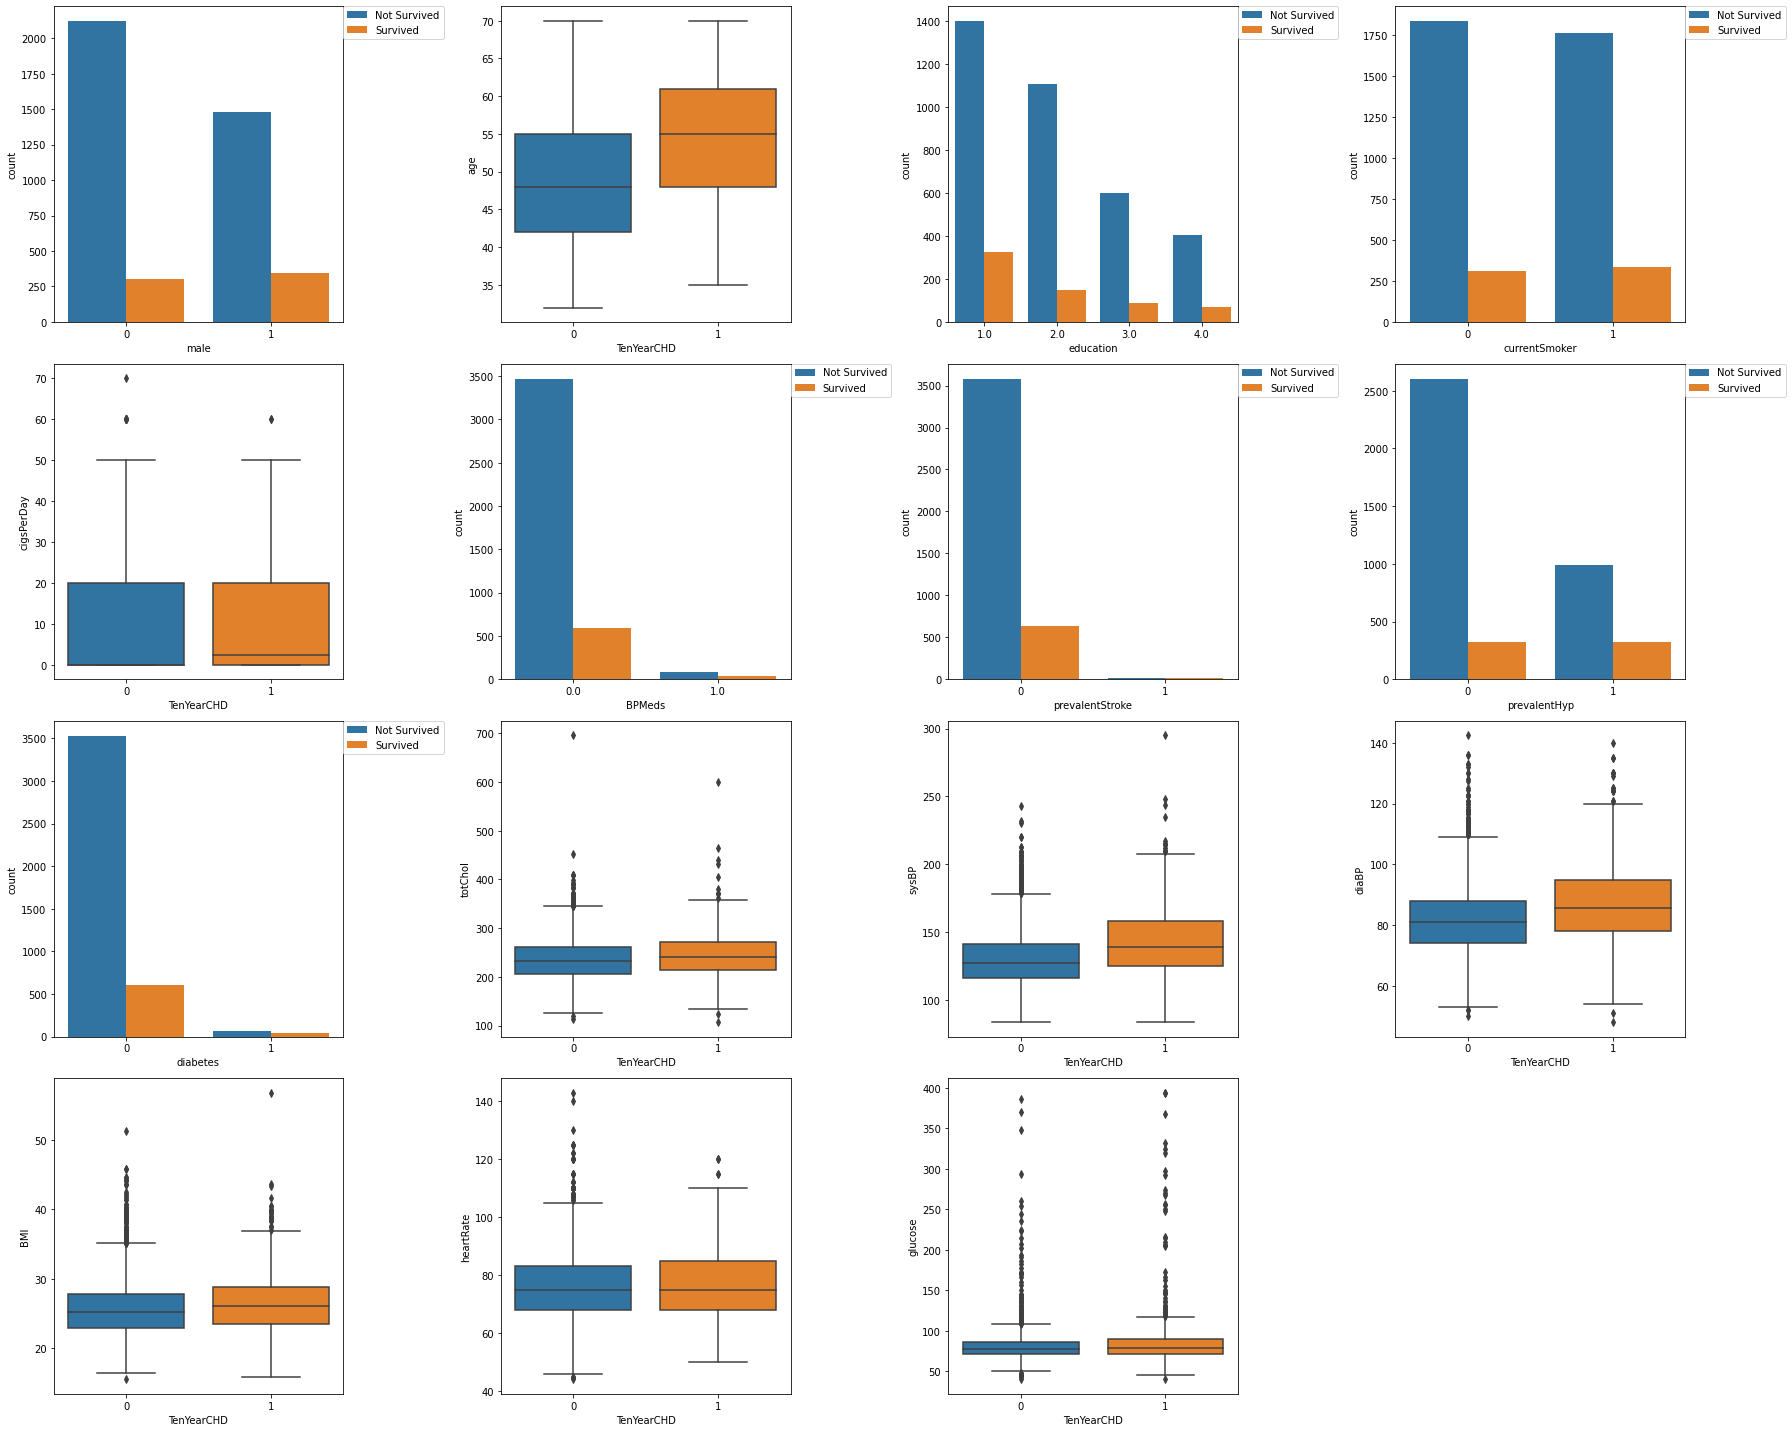

In [24]:
bivariate()

#### Missing Values

In [25]:
dfp.isnull().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [26]:
# % of all missing var
miss_df = pd.DataFrame(dfp.isnull().sum(), columns=['Miss_Values'])
for i in miss_df.index:
    val = miss_df._get_value(i, miss_df.columns[0]) 
    if val > 0:
        print(i, "% : ", val*100/dfp.shape[0])

education % :  2.4764150943396226
cigsPerDay % :  0.6839622641509434
BPMeds % :  1.25
totChol % :  1.179245283018868
BMI % :  0.4481132075471698
heartRate % :  0.02358490566037736
glucose % :  9.150943396226415


In [27]:
# Case 1: Drop All Null Values.
dfp.dropna(inplace=True)
dfp.isnull().sum()

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

In [28]:
dfp.TenYearCHD = le.fit_transform(dfp.TenYearCHD)
dfp.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [75]:
dfp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3658 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   male             3658 non-null   category
 1   age              3658 non-null   int64   
 2   education        3658 non-null   category
 3   currentSmoker    3658 non-null   category
 4   cigsPerDay       3658 non-null   float64 
 5   BPMeds           3658 non-null   category
 6   prevalentStroke  3658 non-null   category
 7   prevalentHyp     3658 non-null   category
 8   diabetes         3658 non-null   category
 9   totChol          3658 non-null   float64 
 10  sysBP            3658 non-null   float64 
 11  diaBP            3658 non-null   float64 
 12  BMI              3658 non-null   float64 
 13  heartRate        3658 non-null   float64 
 14  glucose          3658 non-null   float64 
 15  TenYearCHD       3658 non-null   int64   
dtypes: category(7), float64(7), int64(2)
memor

#### Model Building

##### 1. Logistic Regression

In [ ]:
x = df.loc[:, df.columns != y]
y = df.loc[:, y]

x = x.apply(LabelEncoder().fit_transform)

model = sm.Logit(y, ac(x))
res = model.fit()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.375116
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             TenYearCHD   No. Observations:                 2926
Model:                          Logit   Df Residuals:                     2910
Method:                           MLE   Df Model:                           15
Date:                Sat, 30 Jul 2022   Pseudo R-squ.:                  0.1176
Time:                        17:00:17   Log-Likelihood:                -1097.6
converged:                       True   LL-Null:                       -1243.9
Covariance Type:            nonrobust   LLR p-value:                 1.838e-53
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -4.6573      0.326    -14.305      0.000      -5.295      -4.019
male          

In [35]:
params_lg = {
    'penalty': ['l1', 'l2','elasticnet'],
    'tol': [0.1, 0.01],
    'C': [0.1, 0.01],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [10, 100],
    'multi_class': ['auto', 'ovr','multinomial'],
    'n_jobs': [3,4],
}

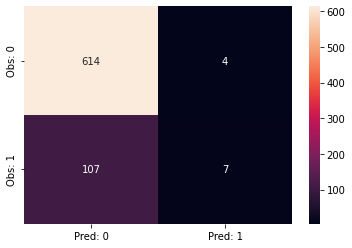

Sensitivity:  0.06140350877192982
Specificity:  0.9935275080906149
Precision:  0.6363636363636364
Accuracy:  0.8483606557377049


(LogisticRegression(C=0.1, multi_class='ovr', n_jobs=4, penalty='l1',
                    solver='liblinear', tol=0.01),
 0.8483606557377049)

In [38]:
# Accuracy Before Back feature Elimination.

# grid_search(model = LogisticRegression(), params =  params_lg, df = dfp, cm='yes')

No Sampling: 


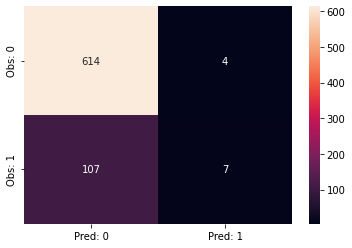

Sensitivity:  0.06140350877192982
Specificity:  0.9935275080906149
Precision:  0.6363636363636364
Accuracy:  0.8483606557377049
SMOTE: 


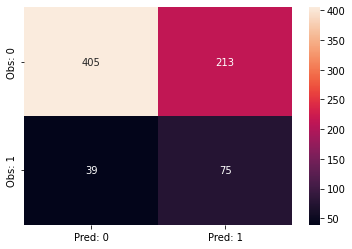

Sensitivity:  0.6578947368421053
Specificity:  0.6553398058252428
Precision:  0.2604166666666667
Accuracy:  0.6557377049180327
NearMiss: 


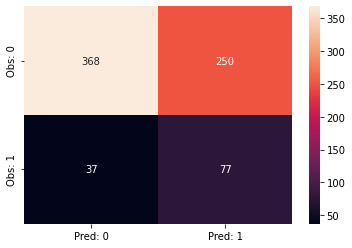

Sensitivity:  0.6754385964912281
Specificity:  0.5954692556634305
Precision:  0.23547400611620795
Accuracy:  0.6079234972677595
Both: 


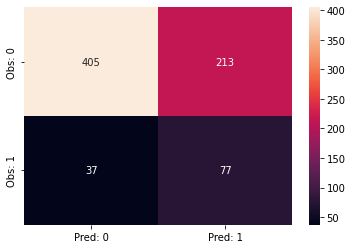

Sensitivity:  0.6754385964912281
Specificity:  0.6553398058252428
Precision:  0.2655172413793103
Accuracy:  0.6584699453551912
No Sampling Done  : 0.8483606557377049
Over              : 0.6557377049180327
Under             : 0.6079234972677595
Both              : 0.6584699453551912

Best way in LogisticRegression model is: No Sampling Done


In [39]:
all_samp_acc(model = LogisticRegression(), params = params_lg, df = dfp, cm='yes')

In [55]:
# Removing cols with p-value more than 0.05

def back_feat_elem(df = dfp, y = target_var):
    x = df.loc[:, df.columns != y]
    y = df.loc[:, y]

    x = x.apply(LabelEncoder().fit_transform)

    col = x.columns

    while len(col) > 0:
        model = sm.Logit(y, ac(x[col]))
        result = model.fit(disp= 0)
        largest_pvalue = round(result.pvalues, 3).nlargest(1)
        if largest_pvalue[0] < (0.05):
            return result
            break
        else:
            col = col.drop(largest_pvalue.index)  

In [54]:
back_res = back_feat_elem()
back_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 3658
Model:                          Logit   Df Residuals:                     3652
Method:                           MLE   Df Model:                            5
Date:                Sat, 30 Jul 2022   Pseudo R-squ.:                  0.1119
Time:                        17:14:59   Log-Likelihood:                -1385.9
converged:                       True   LL-Null:                       -1560.6
Covariance Type:            nonrobust   LLR p-value:                 2.417e-73
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.7474      0.201    -23.649      0.000      -5.141      -4.354
male           0.5235      0.105      4.976      0.000       0.317       0.730
age            0.0678      0.006     10.591      0.000       0.055       0.080
cigsPerDay     0.0255      0.005      4.803      0.000       0.015       0.036
sysBP          0.0096      0.001      8.440      0.000       0.007       0.012
glucose        0.0097      0.003      3.750      0.000       0.005       0.015
==============================================================================
"""

In [57]:
ind = list(back_res.params.index)
ind.remove('const')
# To Insert Imp Cols that I like.
# ind.extend([''])
ind

['male', 'age', 'cigsPerDay', 'sysBP', 'glucose']

In [58]:
new_x = dfp[ind]
new_y = dfp.TenYearCHD
new_df = pd.concat([new_x,new_y], axis=1)
new_df.head()

,male,age,cigsPerDay,sysBP,glucose,TenYearCHD
0,1,39,0.0,106.0,77.0,0
1,0,46,0.0,121.0,76.0,0
2,1,48,20.0,127.5,70.0,0
3,0,61,30.0,150.0,103.0,1
4,0,46,23.0,130.0,85.0,0


Lowering the threshold from 0.5 to a lower value.

In [ ]:
# for i in range(1,6):
#     y_pred_yes = logreg.predict_proba(x_test)
#     binarize = Binarizer(threshold=i/10)
#     y_pred2 = binarize.fit_transform(y_pred_yes)[:,1]

#     print(i/10)
#     cm_mat = confusion_matrix(y_test, y_pred2)
#     cm_data(cm_mat)

# 0.2 Threshlod looks good. Might try it later.

No Sampling: 


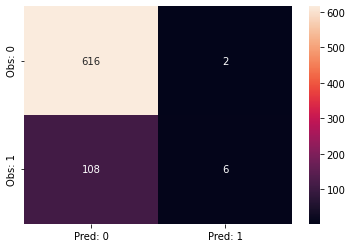

Sensitivity:  0.05263157894736842
Specificity:  0.9967637540453075
Precision:  0.75
Accuracy:  0.8497267759562842
SMOTE: 


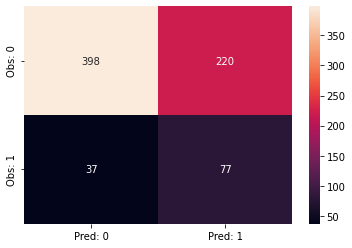

Sensitivity:  0.6754385964912281
Specificity:  0.6440129449838188
Precision:  0.25925925925925924
Accuracy:  0.6489071038251366
NearMiss: 


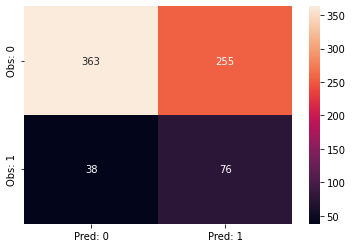

Sensitivity:  0.6666666666666666
Specificity:  0.587378640776699
Precision:  0.229607250755287
Accuracy:  0.5997267759562842
Both: 


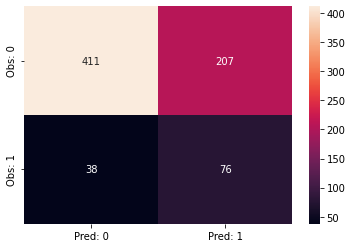

Sensitivity:  0.6666666666666666
Specificity:  0.6650485436893204
Precision:  0.26855123674911663
Accuracy:  0.6653005464480874
No Sampling Done  : 0.8497267759562842
Over              : 0.6489071038251366
Under             : 0.5997267759562842
Both              : 0.6653005464480874

Best way in LogisticRegression model is: No Sampling Done


In [76]:
all_samp_acc(model = LogisticRegression(), params = params_lg, df = dfp, cm='yes')

No Sampling: 


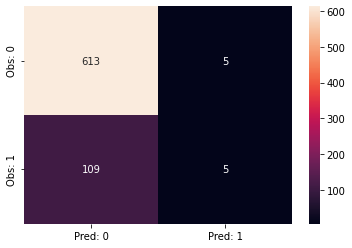

Sensitivity:  0.043859649122807015
Specificity:  0.9919093851132686
Precision:  0.5
Accuracy:  0.8442622950819673
SMOTE: 


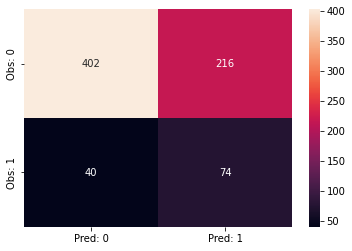

Sensitivity:  0.6491228070175439
Specificity:  0.6504854368932039
Precision:  0.25517241379310346
Accuracy:  0.6502732240437158
NearMiss: 


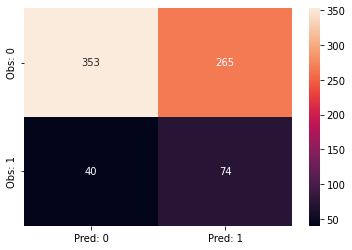

Sensitivity:  0.6491228070175439
Specificity:  0.5711974110032363
Precision:  0.2182890855457227
Accuracy:  0.5833333333333334
Both: 


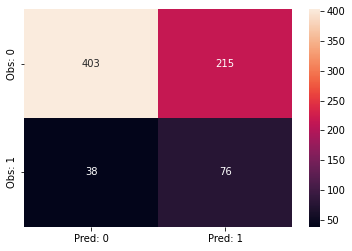

Sensitivity:  0.6666666666666666
Specificity:  0.6521035598705501
Precision:  0.2611683848797251
Accuracy:  0.6543715846994536
No Sampling Done  : 0.8442622950819673
Over              : 0.6502732240437158
Under             : 0.5833333333333334
Both              : 0.6543715846994536

Best way in LogisticRegression model is: No Sampling Done


In [77]:
all_samp_acc(model = LogisticRegression(), params = params_lg, df = new_df, cm='yes')

The Accuracy is very low, So lets try other models.

##### 2: Decision Tree Classifier

In [61]:
new_df.TenYearCHD = new_df.TenYearCHD.astype('category')
new_df.TenYearCHD.dtype

CategoricalDtype(categories=[0, 1], ordered=False)

In [62]:
params_dt = {
    'criterion': ['gini','entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [3, 6, 9],
    'min_samples_leaf': [5, 8, 11],
    'max_features': ['sqrt', 'log2'],
}

No Sampling: 


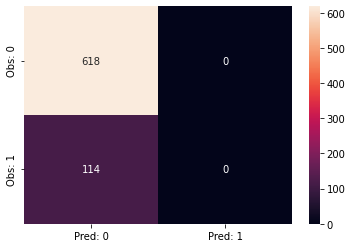

Sensitivity:  0.0
Specificity:  1.0
Precision:  nan
Accuracy:  0.8442622950819673
SMOTE: 


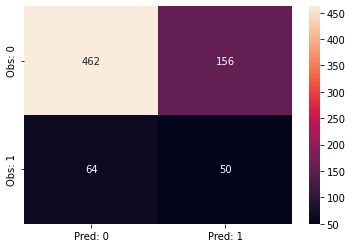

Sensitivity:  0.43859649122807015
Specificity:  0.7475728155339806
Precision:  0.24271844660194175
Accuracy:  0.6994535519125683
NearMiss: 


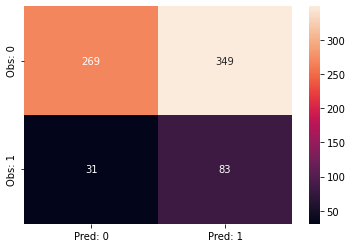

Sensitivity:  0.7280701754385965
Specificity:  0.43527508090614886
Precision:  0.19212962962962962
Accuracy:  0.4808743169398907
Both: 


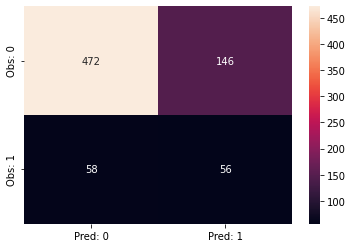

Sensitivity:  0.49122807017543857
Specificity:  0.7637540453074434
Precision:  0.27722772277227725
Accuracy:  0.7213114754098361
No Sampling Done  : 0.8442622950819673
Over              : 0.6994535519125683
Under             : 0.4808743169398907
Both              : 0.7213114754098361

Best way in DecisionTreeClassifier model is: No Sampling Done


In [78]:
all_samp_acc(model = DecisionTreeClassifier(), params = params_dt, df = dfp, cm='yes')

No Sampling: 


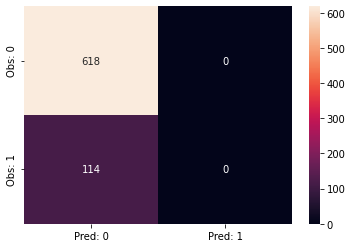

Sensitivity:  0.0
Specificity:  1.0
Precision:  nan
Accuracy:  0.8442622950819673
SMOTE: 


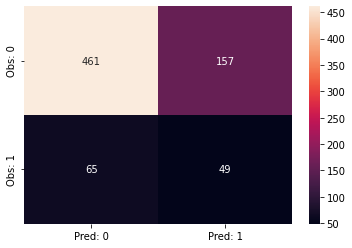

Sensitivity:  0.4298245614035088
Specificity:  0.7459546925566343
Precision:  0.23786407766990292
Accuracy:  0.6967213114754098
NearMiss: 


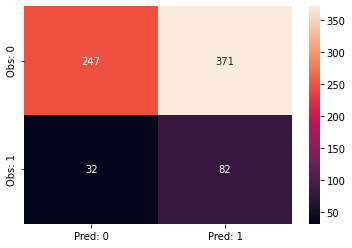

Sensitivity:  0.7192982456140351
Specificity:  0.39967637540453077
Precision:  0.18101545253863136
Accuracy:  0.4494535519125683
Both: 


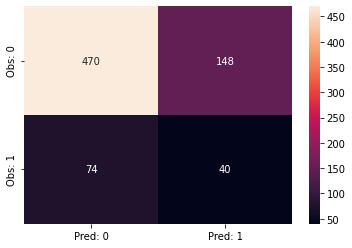

Sensitivity:  0.3508771929824561
Specificity:  0.7605177993527508
Precision:  0.2127659574468085
Accuracy:  0.6967213114754098
No Sampling Done  : 0.8442622950819673
Over              : 0.6967213114754098
Under             : 0.4494535519125683
Both              : 0.6967213114754098

Best way in DecisionTreeClassifier model is: No Sampling Done


In [79]:
all_samp_acc(model = DecisionTreeClassifier(), params = params_dt, df = new_df, cm='yes')

In Decision Tree, all the confusion matrix parameters are slighlty better for the new DataFrame. 
and a lot better than Logistic Regression.

##### 3: KNN Classification

In [65]:
params_knn = {
    'n_neighbors': [1, 3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'n_jobs': [-1],
    'p':[0,1,2,i]
}

No Sampling: 


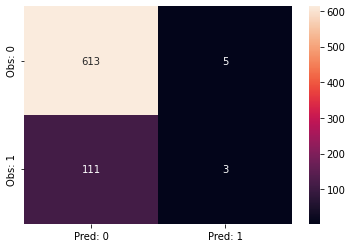

Sensitivity:  0.02631578947368421
Specificity:  0.9919093851132686
Precision:  0.375
Accuracy:  0.8415300546448088
SMOTE: 


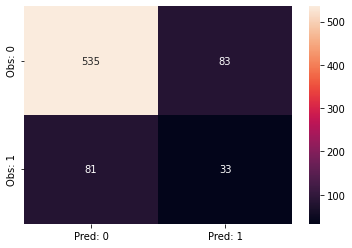

Sensitivity:  0.2894736842105263
Specificity:  0.8656957928802589
Precision:  0.28448275862068967
Accuracy:  0.7759562841530054
NearMiss: 


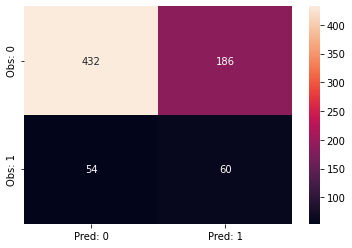

Sensitivity:  0.5263157894736842
Specificity:  0.6990291262135923
Precision:  0.24390243902439024
Accuracy:  0.6721311475409836
Both: 


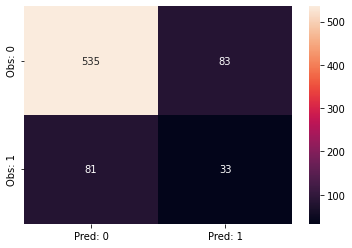

Sensitivity:  0.2894736842105263
Specificity:  0.8656957928802589
Precision:  0.28448275862068967
Accuracy:  0.7759562841530054
No Sampling Done  : 0.8415300546448088
Over              : 0.7759562841530054
Under             : 0.6721311475409836
Both              : 0.7759562841530054

Best way in KNeighborsClassifier model is: No Sampling Done


In [80]:
all_samp_acc(model = KNeighborsClassifier(), params = params_knn, df = dfp, cm='yes')

No Sampling: 


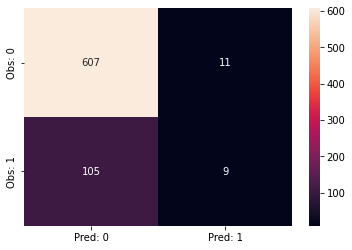

Sensitivity:  0.07894736842105263
Specificity:  0.982200647249191
Precision:  0.45
Accuracy:  0.8415300546448088
SMOTE: 


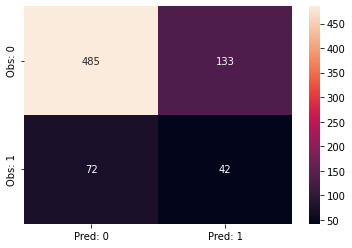

Sensitivity:  0.3684210526315789
Specificity:  0.7847896440129449
Precision:  0.24
Accuracy:  0.7199453551912568
NearMiss: 


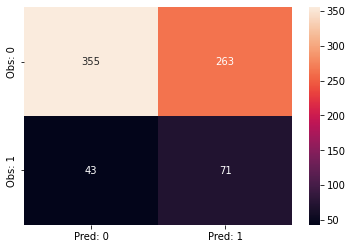

Sensitivity:  0.6228070175438597
Specificity:  0.5744336569579288
Precision:  0.2125748502994012
Accuracy:  0.5819672131147541
Both: 


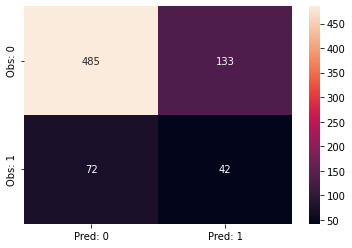

Sensitivity:  0.3684210526315789
Specificity:  0.7847896440129449
Precision:  0.24
Accuracy:  0.7199453551912568
No Sampling Done  : 0.8415300546448088
Over              : 0.7199453551912568
Under             : 0.5819672131147541
Both              : 0.7199453551912568

Best way in KNeighborsClassifier model is: No Sampling Done


In [81]:
all_samp_acc(model = KNeighborsClassifier(), params = params_knn, df = new_df, cm='yes')

##### 4: SVM

In [67]:
# To be done in the future

##### 5: Neural Networks

In [68]:
# To be done in the future

##### 6: Complex SVM

In [69]:
# To be done in the future

##### 7: Complex Neural Networks 

In [70]:
# To be done in the future

##### 8: Random Forest Classifier

Using GridSearchCV for Random Forest Classifier

In [71]:
rf_params = {
    'n_estimators': [10, 50, 100, 150, 200],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [10, 15, 20, 25, 40],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'oob_score': [True],
    'n_jobs': [3],
}

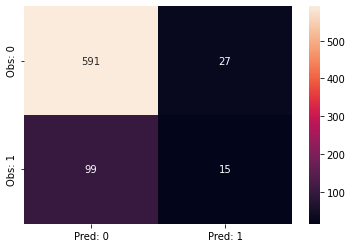

Sensitivity:  0.13157894736842105
Specificity:  0.9563106796116505
Precision:  0.35714285714285715
Accuracy:  0.8278688524590164


In [82]:
model_rf, acc_rf = grid_search(model=RandomForestClassifier(), params=rf_params, df = dfp, samp='o', cm='yes')

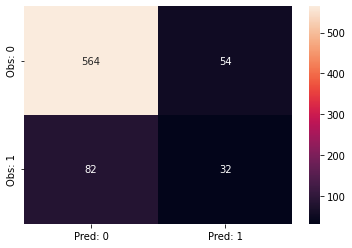

Sensitivity:  0.2807017543859649
Specificity:  0.912621359223301
Precision:  0.37209302325581395
Accuracy:  0.8142076502732241


In [83]:
model_rf, acc_rf = grid_search(model=RandomForestClassifier(), params=rf_params, df = new_df, samp='o', cm='yes')

In [73]:
# all_samp_acc(model = RandomForestClassifier(), params = rf_params, df = new_df, cm='yes')

In Random Forest, the old DataFrame (dfp) is slightly better than the new one.

##### 9: Boosting